# Power Spectrum Analysis

## Configuration

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import pickle
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
from deep_dss.helpers import *
import pymaster as nmt
import warnings

warnings.filterwarnings(action='once')

# Run on GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
# Defaults
plt.rcParams.update({
'lines.color':'black',
'font.family':'serif',
'font.weight':'normal',
'text.color':'black',
'text.usetex': True,
'axes.edgecolor':'black',
'axes.linewidth':1.0,
'axes.titlesize':'x-large',
'axes.labelsize':'x-large',
'axes.labelcolor':'black',
'xtick.labelsize':'x-large',
'xtick.minor.width':1.0,
'xtick.major.width':1.0,
'ytick.major.size':7,
'ytick.minor.size':4,
'ytick.major.pad':8,
'ytick.minor.pad':8,
'ytick.labelsize':'x-large',
'ytick.minor.width':1.0,
'ytick.major.width':1.0,
'legend.numpoints':1,
'legend.fontsize':'x-large',
'legend.shadow':False,
'legend.frameon':False})

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Config variables
config = "ck"
zscale = False
nside = 1024
order = 2
gaussian = False
free_bias = True
prior_low = 0.8
prior_high = 3.0

In [9]:
# Using covariance Q1 data
data = split_count_and_lensing_maps_by_dataset("COVQ1", config=config, covariance=True, zscale=zscale,
                                              gaussian=gaussian, free_bias=free_bias,
                                              prior_low=prior_low, prior_high=prior_high)
# data = split_count_and_lensing_maps_by_vals([201], config=config, covariance=True, zscale=zscale)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site

In [10]:
data

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'x': array([[[ 0.00000000e+00, -1.69348790e-03],
         [ 4.00000000e+00, -9.06981927e-03],
         [ 0.00000000e+00,  1.64133731e-02],
         ...,
         [ 1.00000000e+00, -8.59071175e-03],
         [ 0.00000000e+00, -5.29450974e-02],
         [ 0.00000000e+00,  1.63855896e-03]],
 
        [[ 0.00000000e+00,  5.45150262e-04],
         [ 1.00000000e+00, -1.97127091e-02],
         [ 1.00000000e+00,  3.01980978e-02],
         ...,
         [ 0.00000000e+00, -1.37313476e-03],
         [ 0.00000000e+00,  1.77806757e-02],
         [ 0.00000000e+00, -1.98674592e-02]],
 
        [[ 0.00000000e+00,  6.26161417e-03],
         [ 1.00000000e+00,  1.21479080e-02],
         [ 0.00000000e+00, -9.14841312e-03],
         ...,
         [ 0.00000000e+00, -7.65952836e-03],
         [ 1.00000000e+00,  1.18045536e-02],
         [ 1.00000000e+00,  2.27854886e-02]],
 
        ...,
 
        [[ 0.00000000e+00, -1.87623997e-02],
         [ 0.00000000e+00,  1.52492365e-02],
         [ 0.00000000e+00, -3

In [11]:
data = data["x"]
data.shape

(1920, 262144, 2)

## Computing C_ells

In [12]:
bias = 1.54
density_arcmins = 0.04377 # Tracer density, galaxies/arcmin^2
density_steradians = density_arcmins * 3600 * (180/np.pi)**2

In [13]:
density_steradians

517278.36218405055

In [14]:
# Create mask for partial sky maps
mask_map = np.zeros(hp.nside2npix(nside))
mask_map[:(nside//order)**2] = 1
mask_map = hp.reorder(mask_map, n2r=True)
apod = 3
mask = nmt.mask_apodization(mask_map,
                            apod/60, apotype="Smooth")

<>:1: DeprecationWarning: invalid escape sequence \e
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


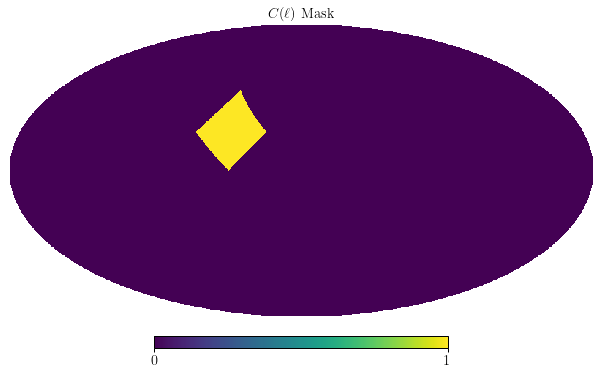

In [15]:
hp.mollview(mask_map, title="$C(\ell)$ Mask")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 

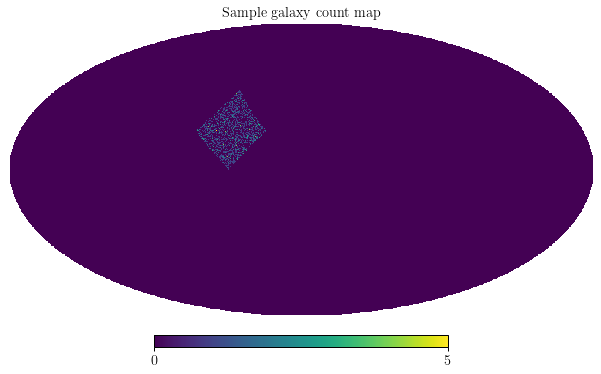

In [16]:
# Create full-sky version of counts map

count_map = np.zeros(hp.nside2npix(nside))
count_map[:(nside//order)**2] = np.copy(data[0,:,0])
count_map = hp.reorder(count_map, n2r=True)
hp.mollview(count_map, title="Sample galaxy count map")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 

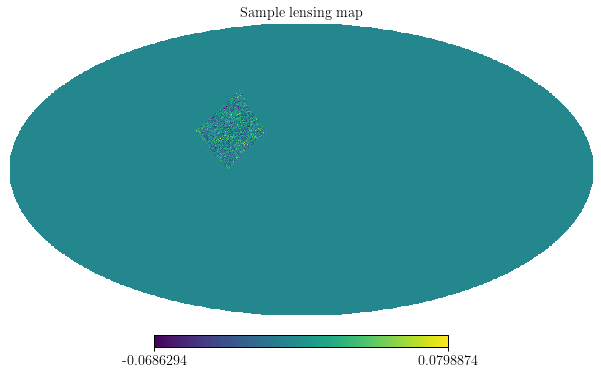

In [17]:
# Create full-sky version of lensing map
lensing_map = np.zeros(hp.nside2npix(nside))
lensing_map[:(nside//order)**2] = np.copy(data[0,:,1])
lensing_map = hp.reorder(lensing_map, n2r=True)
hp.mollview(lensing_map, title="Sample lensing map")

In [18]:
# Create Namaster fields from maps
count_field = nmt.NmtField(mask, [count_map])
lensing_field = nmt.NmtField(mask, [lensing_map])

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
full_count_map = np.reshape(data[:,:,0], (48*262144))
full_lensing_map = np.reshape(data[:,:,1], (48*262144))

ValueError: cannot reshape array of size 503316480 into shape (12582912,)

In [ ]:
full_count_map = hp.reorder(full_count_map, n2r=True)
full_lensing_map = hp.reorder(full_lensing_map, n2r=True)

In [ ]:
hp.mollview(full_count_map, title="Full count map")

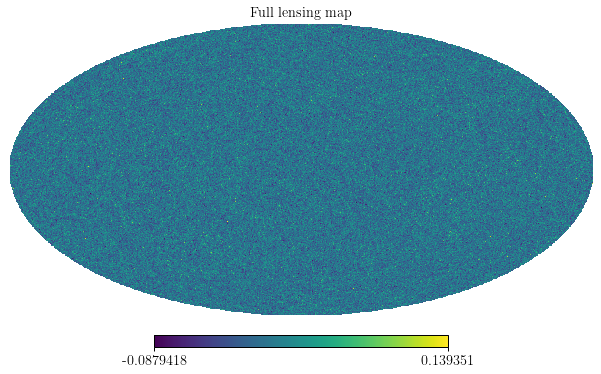

In [88]:
hp.mollview(full_lensing_map, title="Full lensing map")

In [ ]:
full_mask = nmt.mask_apodization(np.zeros(hp.nside2npix(nside)),
                            1., apotype="Smooth")

In [ ]:
# Create Namaster fields from maps
# full_count_field = nmt.NmtField(full_mask, [full_count_map])
# full_lensing_field = nmt.NmtField(full_mask, [full_lensing_map])

In [ ]:
# Initialize binning scheme with four ells per bandpower
bin_power = 64
binning = nmt.NmtBin.from_nside_linear(nside, bin_power)
ell_arr = binning.get_effective_ells()
print(ell_arr)

In [282]:
# # Compute MASTER estimator
# cl_gg_full = nmt.compute_full_master(full_count_field, full_count_field, binning)
# cl_gk_full = nmt.compute_full_master(full_count_field, full_lensing_field, binning)
# cl_kk_full = nmt.compute_full_master(full_lensing_field, full_lensing_field, binning)

In [ ]:
# Compute MASTER estimator
cl_gg = nmt.compute_full_master(count_field, count_field, binning)
cl_gk = nmt.compute_full_master(count_field, lensing_field, binning)
cl_kk = nmt.compute_full_master(lensing_field, lensing_field, binning)

In [ ]:
cl_gg_ana = hp.anafast(full_count_map)
cl_gk_ana = hp.anafast(full_count_map, map2=full_lensing_map)
cl_kk_ana = hp.anafast(full_lensing_map, map2=full_lensing_map)

In [ ]:
masked_count_map = hp.reorder(count_map, r2n=True)
masked_lensing_map = hp.reorder(lensing_map, r2n=True)
masked_count_map[(nside//order)**2:12*nside**2] = hp.UNSEEN
masked_lensing_map[(nside//order)**2:12*nside**2] = hp.UNSEEN
masked_count_map = hp.ma(masked_count_map)
masked_lensing_map = hp.ma(masked_lensing_map)
masked_count_map = hp.reorder(masked_count_map, n2r=True)
masked_lensing_map = hp.reorder(masked_lensing_map, n2r=True)

In [ ]:
cl_gg_ana_p = hp.anafast(masked_count_map)
cl_gk_ana_p = hp.anafast(masked_count_map, map2=masked_lensing_map)
cl_kk_ana_p = hp.anafast(masked_lensing_map, map2=masked_lensing_map)

In [ ]:
cl_gg_ana

In [ ]:
cl_gk_ana

In [ ]:
cl_kk_ana

In [ ]:
cl_gg_ana_p

In [ ]:
cl_gk_ana_p

In [ ]:
cl_kk_ana_p

In [ ]:
cl_gg

In [ ]:
cl_gk

In [ ]:
cl_kk

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

minscale = 20

axs[0].plot(ell_arr[int(np.floor(minscale/bin_power)):], cl_gg[0,int(np.floor(minscale/bin_power)):])
axs[0].set_title("MASTER estimate for galaxy auto-correlation", pad=20)
axs[1].plot(ell_arr[int(np.floor(minscale/bin_power)):], cl_kk[0,int(np.floor(minscale/bin_power)):])
axs[1].set_title("MASTER estimate for lensing auto-correlation", pad=20)
axs[2].plot(ell_arr[int(np.floor(minscale/bin_power)):], cl_kk[0,int(np.floor(minscale/bin_power)):])
axs[2].set_title("MASTER estimate for lensing auto-correlation", pad=20)

fig.suptitle(r"$C(\ell)$ measurements, ${0} \leq \ell \leq {1}$, $b={2}$, $\theta={3}$'".format(minscale,
                                                                                              3*nside, bin_power,
                                                                                             apod),
            fontsize=18)

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

minscale = 20

axs[0].plot(np.arange(3*nside)[minscale:], cl_gg_ana_p[minscale:])
axs[0].set_title("Anafast partial-sky estimate for galaxy auto-correlation", pad=20)
axs[1].plot(np.arange(3*nside)[minscale:], cl_gk_ana_p[minscale:])
axs[1].set_title("Anafast partial-sky estimate for galaxy-lensing cross-correlation", pad=20)
axs[2].plot(np.arange(3*nside)[minscale:], cl_kk_ana_p[minscale:])
axs[2].set_title("Anafast partial-sky estimate for lensing auto-correlation", pad=20)

fig.suptitle("$C(\ell)$ measurements, ${0} \leq \ell \leq {1}$".format(minscale, 3*nside),
            fontsize=18)

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

minscale = 20

axs[0].plot(np.arange(3*nside)[minscale:], cl_gg_ana[minscale:])
axs[0].set_title("Anafast full-sky estimate for galaxy auto-correlation", pad=20)
axs[1].plot(np.arange(3*nside)[minscale:], cl_gk_ana[minscale:])
axs[1].set_title("Anafast full-sky estimate for galaxy-lensing cross-correlation", pad=20)
axs[2].plot(np.arange(3*nside)[minscale:], cl_kk_ana[minscale:])
axs[2].set_title("Anafast full-sky estimate for lensing auto-correlation", pad=20)

fig.suptitle("$C(\ell)$ measurements, ${0} \leq \ell \leq {1}$".format(minscale, 3*nside),
            fontsize=18)

fig.tight_layout()

In [ ]:
c_ell_path = "../data/flaskv3/input/dss-0.85/dss-0.85-Cl-"

In [ ]:
cl_gg_trough = pd.read_csv(c_ell_path+"f1z1f1z1.dat", sep=' ', header=None)
cl_gg_trough.columns = ['L', 'CL']
cl_gg_trough.index = np.arange(10000)

In [ ]:
cl_gg_trough['CL'] = cl_gg_trough['CL']*bias**2 + 1/density_steradians

In [ ]:
cl_gg_trough

In [ ]:
cl_gg_trough = cl_gg_trough['CL'][:3*nside].to_numpy()

In [ ]:
cl_gk_trough = pd.read_csv(c_ell_path+"f1z1f2z1.dat", sep=' ', header=None)
cl_gk_trough.columns = ['L', 'CL']
cl_gk_trough.index = np.arange(10000)

In [ ]:
cl_gk_trough['CL'] = bias*cl_gk_trough['CL']

In [ ]:
cl_gk_trough = cl_gk_trough['CL'][:3*nside].to_numpy()

In [ ]:
cl_gk_trough

In [ ]:
cl_k1k1_trough = pd.read_csv(c_ell_path+"f2z1f2z1.dat", sep=' ', header=None)
cl_k1k1_trough.columns = ['L', 'CL']
cl_k1k1_trough.index = np.arange(10000)

cl_k2k2_trough = pd.read_csv(c_ell_path+"f2z2f2z2.dat", sep=' ', header=None)
cl_k2k2_trough.columns = ['L', 'CL']
cl_k2k2_trough.index = np.arange(10000)

cl_kk_trough = pd.read_csv(c_ell_path+"f1z1f2z1.dat", sep=' ', header=None)
cl_kk_trough.columns = ['L', 'CL']
cl_kk_trough.index = np.arange(10000)
cl_kk_trough['CL'] = cl_k1k1_trough['CL'] + cl_k2k2_trough['CL']

In [ ]:
cl_kk_trough = cl_kk_trough['CL'][:3*nside].to_numpy()

In [ ]:
cl_kk_trough

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

minscale = 20

axs[0].plot(np.arange(3*nside)[minscale:], cl_gg_trough[minscale:3*nside])
axs[0].set_title("Troughlenser prediction for galaxy auto-correlation", pad=20)
axs[1].plot(np.arange(3*nside)[minscale:], cl_gk_trough[minscale:3*nside])
axs[1].set_title("Troughlenser prediction for galaxy-lensing cross-correlation", pad=20)
axs[2].plot(np.arange(3*nside)[minscale:], cl_kk_trough[minscale:3*nside])
axs[2].set_title("Troughlenser prediction for lensing auto-correlation", pad=20)

fig.suptitle("$C(\ell)$ predictions, ${0} \leq \ell \leq {1}$".format(minscale, 3*nside),
            fontsize=18)

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

minscale = 20

axs[0,0].plot(ell_arr[int(np.floor(minscale/bin_power)):], 
              cl_gg[0, int(np.floor(minscale/bin_power)):], 'b-', label='MASTER partial')
axs[0,0].plot(np.arange(3*nside)[minscale:3*nside], cl_gg_trough[minscale:3*nside],
         'r-', label='troughlenser')
axs[0,0].legend()
axs[0,0].set_title("Predicted vs. measured galaxy auto-correlations", pad=20)

axs[0,1].plot(ell_arr[int(np.floor(minscale/bin_power)):], 
              cl_gk[0, int(np.floor(minscale/bin_power)):], 'b-', label='MASTER partial')
axs[0,1].plot(np.arange(3*nside)[minscale:3*nside], cl_gk_trough[minscale:3*nside],
         'r-', label='troughlenser')
axs[0,1].legend()
axs[0,1].set_title("Predicted vs. measured galaxy-lensing cross-correlations", pad=20)

axs[0,2].plot(ell_arr[int(np.floor(minscale/bin_power)):], 
              cl_kk[0, int(np.floor(minscale/bin_power)):], 'b-', label='MASTER partial')
axs[0,2].plot(np.arange(3*nside)[minscale:3*nside], cl_kk_trough[minscale:3*nside],
         'r-', label='troughlenser')
axs[0,2].legend()
axs[0,2].set_title("Predicted vs. measured lensing auto-correlations", pad=20)

axs[1,0].plot(np.arange(3*nside)[minscale:], cl_gg_ana[minscale:], 'b-', label='anafast full')
axs[1,0].plot(np.arange(3*nside)[minscale:3*nside], cl_gg_trough[minscale:3*nside],
         'r-', label='troughlenser')
axs[1,0].legend()
axs[1,0].set_title("Predicted vs. measured galaxy auto-correlations", pad=20)

axs[1,1].plot(np.arange(3*nside)[minscale:], cl_gk_ana[minscale:], 'b-', label='anafast full')
axs[1,1].plot(np.arange(3*nside)[minscale:3*nside], cl_gk_trough[minscale:3*nside],
         'r-', label='troughlenser')
axs[1,1].legend()
axs[1,1].set_title("Predicted vs. measured galaxy-lensing cross-correlations", pad=20)

axs[1,2].plot(np.arange(3*nside)[minscale:], cl_kk_ana[minscale:], 'b-', label='anafast full')
axs[1,2].plot(np.arange(3*nside)[minscale:3*nside], cl_kk_trough[minscale:3*nside], 
              'r-', label='troughlenser')
axs[1,2].legend()
axs[1,2].set_title("Predicted vs. measured lensing auto-correlations", pad=20)

axs[2,0].plot(np.arange(3*nside)[minscale:], cl_gg_ana_p[minscale:], 'b-', label='anafast partial')
axs[2,0].plot(np.arange(3*nside)[minscale:3*nside], cl_gg_trough[minscale:3*nside],
         'r-', label='troughlenser')
axs[2,0].legend()
axs[2,0].set_title("Predicted vs. measured galaxy auto-correlations", pad=20)

axs[2,1].plot(np.arange(3*nside)[minscale:], cl_gk_ana_p[minscale:], 'b-', label='anafast partial')
axs[2,1].plot(np.arange(3*nside)[minscale:3*nside], cl_gk_trough[minscale:3*nside],
         'r-', label='troughlenser')
axs[2,1].legend()
axs[2,1].set_title("Predicted vs. measured galaxy-lensing cross-correlations", pad=20)

axs[2,2].plot(np.arange(3*nside)[minscale:], cl_kk_ana_p[minscale:], 'b-', label='anafast partial')
axs[2,2].plot(np.arange(3*nside)[minscale:3*nside], cl_kk_trough[minscale:3*nside], 
              'r-', label='troughlenser')
axs[2,2].legend()
axs[2,2].set_title("Predicted vs. measured lensing auto-correlations", pad=20)

fig.suptitle(r"$C(\ell)$ comparsions, ${0} \leq \ell \leq {1}$, $b={2}$, $\theta={3}$'".format(minscale, 3*nside, 
                                                                                            bin_power, apod),
            fontsize=18)
fig.tight_layout()

In [ ]:
plt.plot(np.arange(3*nside), hp.pixwin(1024))
plt.xlabel("$\ell$-mode")
plt.ylabel("Window function")
plt.title("HEALPIX Pixel Window Function for NSIDE=1024")